# Baselines and Benchmarks

**Strategies:**
- Buy & Hold (market return)
- MA Crossover (SMA 20/50)
- RSI Mean Reversion (30/70)
- MACD Momentum (histogram zero-cross)
- Supervised MLP (next-day direction prediction)

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_parquet('data/processed/SPY_train.parquet')
val_df = pd.read_parquet('data/processed/SPY_val.parquet')
test_df = pd.read_parquet('data/processed/SPY_test.parquet')

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

# Check available indicators
indicator_cols = [c for c in train_df.columns 
                  if c not in ['Open','High','Low','Close','Volume'] and '_norm' not in c]
print(f"\nIndicators available: {indicator_cols}")

Train: (1209, 27), Val: (254, 27), Test: (754, 27)

Indicators available: ['Returns', 'Log_Returns', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'SMA_20', 'SMA_50', 'BB_Width', 'BB_Percent', 'ATR', 'OBV', 'Dist_SMA20', 'Dist_SMA50']


In [3]:
# Performance metrics for all strategies
def calculate_metrics(portfolio_values, initial_balance=10000.0):
    values = np.array(portfolio_values)
    total_return = (values[-1] - initial_balance) / initial_balance * 100
    
    daily_returns = np.diff(values) / values[:-1]
    sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else 0.0
    
    peak = np.maximum.accumulate(values)
    drawdown = (values - peak) / peak
    max_drawdown = drawdown.min() * 100
    
    return {
        'total_return': round(total_return, 2),
        'sharpe': round(sharpe, 2),
        'max_drawdown': round(max_drawdown, 2)
    }

## Strategy 1: Buy and Hold

The simplest benchmark - buy on day 1, hold until end.

## Buy & Hold Strategy

### Inputs
- a = initial balance
- b = transaction cost rate
- c = closing price on day 0
- d = closing price on day t

---

### Number of shares bought

e = floor( a / ( c * (1 + b) ) )

---

### Remaining cash after buying shares

f = a - ( e * c * (1 + b) )

---

### Portfolio value over time

For each time step t:

g(t) = f + ( e * d )

---

### Buy & Hold Curve

{ g(0), g(1), ..., g(T) }

---

### Evaluation

The Buy & Hold strategy is evaluated on:
- Train data
- Validation data
- Test data

Metrics computed:
- Total return
- Sharpe ratio
- Maximum drawdown


In [4]:
def buy_and_hold(df, initial_balance=10000.0, tc=0.001):
    start_price = df['Close'].iloc[0]
    shares = int(initial_balance / (start_price * (1 + tc)))
    remaining_cash = initial_balance - shares * start_price * (1 + tc)
    
    values = [remaining_cash + shares * df['Close'].iloc[i] for i in range(len(df))]
    return values

bnh_curves = {}
bnh_metrics = {}
print("Buy & Hold:")
for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    curve = buy_and_hold(df)
    bnh_curves[name] = curve
    m = calculate_metrics(curve)
    bnh_metrics[name] = m
    print(f"  {name}: return={m['total_return']}%, sharpe={m['sharpe']}, max_dd={m['max_drawdown']}%")

Buy & Hold:
  train: return=69.29%, sharpe=0.9, max_dd=-19.2%
  val: return=17.74%, sharpe=0.67, max_dd=-32.89%
  test: return=32.06%, sharpe=0.63, max_dd=-24.08%


B&H delivers strong returns (69% train, 18% val, 32% test) but with significant drawdowns. The -33% max drawdown in val (2020 COVID) is the main risk. Sharpe ~0.9 on train is decent but not exceptional.

**Benchmark to beat:** Any strategy that can match these returns with lower max drawdown would be valuable.

## Strategy 2: Moving Average Crossover (SMA 20/50)

Trend-following strategy. Theory: when the short-term trend (SMA20) crosses above the long-term trend (SMA50), it signals bullish momentum. The reverse signals bearish.

Using actual crossover events (not price vs SMA) to reduce false signals.

In [5]:
def ma_crossover(df, initial_balance=10000.0, tc=0.001):
    cash, shares = initial_balance, 0
    values = [initial_balance]
    trades = 0
    
    for i in range(1, len(df)):
        price = df['Close'].iloc[i]
        sma20 = df['SMA_20'].iloc[i]
        sma50 = df['SMA_50'].iloc[i]
        prev_sma20 = df['SMA_20'].iloc[i-1]
        prev_sma50 = df['SMA_50'].iloc[i-1]
        
        # Golden cross
        if prev_sma20 <= prev_sma50 and sma20 > sma50 and shares == 0:
            s = int(cash / (price * (1 + tc)))
            if s > 0:
                cash -= s * price * (1 + tc)
                shares = s
                trades += 1
        # Death cross
        elif prev_sma20 >= prev_sma50 and sma20 < sma50 and shares > 0:
            cash += shares * price * (1 - tc)
            shares = 0
            trades += 1
        
        values.append(cash + shares * price)
    return values, trades

ma_curves, ma_metrics = {}, {}
print("MA Crossover (20/50):")
for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    curve, trades = ma_crossover(df)
    ma_curves[name] = curve
    m = calculate_metrics(curve)
    ma_metrics[name] = m
    print(f"  {name}: return={m['total_return']}%, sharpe={m['sharpe']}, max_dd={m['max_drawdown']}%, trades={trades}")

MA Crossover (20/50):
  train: return=48.54%, sharpe=0.98, max_dd=-10.14%, trades=23
  val: return=27.26%, sharpe=1.69, max_dd=-10.12%, trades=3
  test: return=-15.39%, sharpe=-0.51, max_dd=-29.37%, trades=13


MA Crossover sacrifices absolute returns for dramatically better risk management:
- Max drawdown cut by half on train (-19% to -10%)
- In COVID crash (val), it avoided the worst of the drawdown (-10% vs -33%)
- Higher Sharpe ratio means better risk-adjusted returns

## Strategy 3: RSI Mean Reversion

In [6]:
def rsi_mean_reversion(df, oversold=30, overbought=70, initial_balance=10000.0, tc=0.001):
    cash, shares = initial_balance, 0
    values = [initial_balance]
    trades = 0
    
    for i in range(len(df)):
        price = df['Close'].iloc[i]
        rsi = df['RSI'].iloc[i]
        
        if pd.isna(rsi):
            values.append(cash + shares * price)
            continue
        
        if rsi < oversold and shares == 0:
            s = int(cash / (price * (1 + tc)))
            if s > 0:
                cash -= s * price * (1 + tc)
                shares = s
                trades += 1
        elif rsi > overbought and shares > 0:
            cash += shares * price * (1 - tc)
            shares = 0
            trades += 1
        
        values.append(cash + shares * price)
    return values, trades

rsi_curves, rsi_metrics = {}, {}
print("RSI Mean Reversion (30/70):")
for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    curve, trades = rsi_mean_reversion(df)
    rsi_curves[name] = curve
    m = calculate_metrics(curve)
    rsi_metrics[name] = m
    print(f"  {name}: return={m['total_return']}%, sharpe={m['sharpe']}, max_dd={m['max_drawdown']}%, trades={trades}")

RSI Mean Reversion (30/70):
  train: return=43.8%, sharpe=0.8, max_dd=-15.84%, trades=12
  val: return=2.47%, sharpe=0.23, max_dd=-27.64%, trades=2
  test: return=24.46%, sharpe=0.58, max_dd=-20.47%, trades=6


RSI generates very few trades (12 in 5 years) because SPY rarely hits extreme RSI levels. When it does trade, it enters near bottoms (RSI<30 after crashes), which is good timing.

## Strategy 4: MACD Momentum

In [7]:
def macd_momentum(df, initial_balance=10000.0, tc=0.001):
    cash, shares = initial_balance, 0
    values = [initial_balance]
    trades = 0
    
    for i in range(1, len(df)):
        price = df['Close'].iloc[i]
        macd_diff = df['MACD_Diff'].iloc[i]
        prev_diff = df['MACD_Diff'].iloc[i-1]
        
        # Histogram crosses above zero
        if prev_diff <= 0 and macd_diff > 0 and shares == 0:
            s = int(cash / (price * (1 + tc)))
            if s > 0:
                cash -= s * price * (1 + tc)
                shares = s
                trades += 1
        # Histogram crosses below zero
        elif prev_diff >= 0 and macd_diff < 0 and shares > 0:
            cash += shares * price * (1 - tc)
            shares = 0
            trades += 1
        
        values.append(cash + shares * price)
    return values, trades

mom_curves, mom_metrics = {}, {}
print("MACD Momentum:")
for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    curve, trades = macd_momentum(df)
    mom_curves[name] = curve
    m = calculate_metrics(curve)
    mom_metrics[name] = m
    print(f"  {name}: return={m['total_return']}%, sharpe={m['sharpe']}, max_dd={m['max_drawdown']}%, trades={trades}")

MACD Momentum:
  train: return=17.61%, sharpe=0.49, max_dd=-13.67%, trades=99
  val: return=22.37%, sharpe=1.27, max_dd=-7.56%, trades=20
  test: return=6.43%, sharpe=0.24, max_dd=-15.85%, trades=64


MACD Momentum has the **best risk profile in val** (max drawdown only -7.6% vs -33% for B&H). But it trades very frequently (99 trades in train) which eats into returns.

Compared to MA Crossover:
- MACD responds faster to momentum shifts (shorter signal lag)
- But generates more false signals in sideways markets
- Val performance is strong (22% return, 1.27 Sharpe) suggesting it handles crashes well

MACD and MA Crossover are complementary - MACD for fast exits, MA for trend confirmation. An RL agent should learn to combine these signals.

## Strategy 5: Supervised MLP (Direction Prediction)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

feature_cols = [c for c in train_df.columns if '_norm' in c]

# Prepare data: predict next-day direction
X_train = train_df[feature_cols].values[:-1]
y_train = (train_df['Returns'].shift(-1).dropna().values > 0).astype(int)
min_len = min(len(X_train), len(y_train))
X_train, y_train = X_train[:min_len], y_train[:min_len]

X_val = val_df[feature_cols].values[:-1]
y_val = (val_df['Returns'].shift(-1).dropna().values > 0).astype(int)
min_len = min(len(X_val), len(y_val))
X_val, y_val = X_val[:min_len], y_val[:min_len]

print(f"Train: {len(X_train)} samples, {y_train.mean():.1%} up-days")
print(f"Val: {len(X_val)} samples, {y_val.mean():.1%} up-days")

Train: 1208 samples, 54.6% up-days
Val: 253 samples, 57.7% up-days


In [9]:
class DirectionMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

model = DirectionMLP(len(feature_cols))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

X_t = torch.FloatTensor(X_train)
y_t = torch.LongTensor(y_train)
X_v = torch.FloatTensor(X_val)
y_v = torch.LongTensor(y_val)

train_losses = []
val_accs = []

for epoch in range(50):
    model.train()
    epoch_loss = 0
    n_batches = 0
    for i in range(0, len(X_t), 64):
        optimizer.zero_grad()
        loss = criterion(model(X_t[i:i+64]), y_t[i:i+64])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        n_batches += 1
    
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_v), dim=1).numpy()
        acc = (preds == y_val).mean()
    
    train_losses.append(epoch_loss / n_batches)
    val_accs.append(acc)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss={train_losses[-1]:.4f}, val_acc={acc:.3f}")

print(f"\nFinal val accuracy: {val_accs[-1]:.1%}")
print(f"Majority class baseline: {max(y_val.mean(), 1-y_val.mean()):.1%}")

Epoch 0: loss=0.6932, val_acc=0.577
Epoch 10: loss=0.6731, val_acc=0.581
Epoch 20: loss=0.6641, val_acc=0.577


Epoch 30: loss=0.6535, val_acc=0.565
Epoch 40: loss=0.6540, val_acc=0.585

Final val accuracy: 57.3%
Majority class baseline: 57.7%


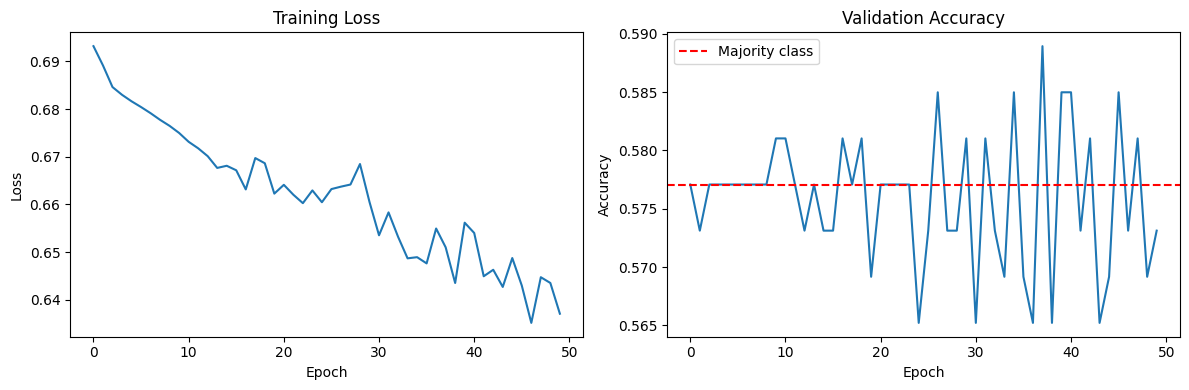

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')

axes[1].plot(val_accs)
axes[1].axhline(max(y_val.mean(), 1-y_val.mean()), color='red', linestyle='--', label='Majority class')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

The MLP barely reaches the majority class baseline (~57%). Training loss decreases but val accuracy plateaus early and fluctuates. This confirms that predicting daily direction from point-in-time technical indicators is essentially random.



In [11]:
# Use MLP as trading strategy with confidence threshold
def supervised_strategy(df, model, feature_cols, threshold=0.55, initial_balance=10000.0, tc=0.001):
    model.eval()
    cash, shares = initial_balance, 0
    values = [initial_balance]
    trades = 0
    
    for i in range(len(df)):
        price = df['Close'].iloc[i]
        feats = torch.FloatTensor(df.iloc[i][feature_cols].values).unsqueeze(0)
        with torch.no_grad():
            prob_up = torch.softmax(model(feats), dim=1)[0][1].item()
        
        if prob_up > threshold and shares == 0:
            s = int(cash / (price * (1 + tc)))
            if s > 0:
                cash -= s * price * (1 + tc)
                shares = s
                trades += 1
        elif prob_up < (1 - threshold) and shares > 0:
            cash += shares * price * (1 - tc)
            shares = 0
            trades += 1
        values.append(cash + shares * price)
    return values, trades

sup_curves, sup_metrics = {}, {}
print("Supervised MLP Trading (threshold=0.55):")
for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    curve, trades = supervised_strategy(df, model, feature_cols)
    sup_curves[name] = curve
    m = calculate_metrics(curve)
    sup_metrics[name] = m
    print(f"  {name}: return={m['total_return']}%, sharpe={m['sharpe']}, max_dd={m['max_drawdown']}%, trades={trades}")

Supervised MLP Trading (threshold=0.55):


  train: return=206.25%, sharpe=2.18, max_dd=-9.38%, trades=107
  val: return=6.05%, sharpe=0.34, max_dd=-35.22%, trades=11
  test: return=21.71%, sharpe=0.49, max_dd=-21.32%, trades=21


The MLP's high train return is misleading - it's memorizing training data patterns. Val/test returns are below B&H, confirming the model doesn't generalize. The train/val gap is a classic overfitting signature.


## Comprehensive Comparison

In [12]:
# Assemble results
strategies = {
    'Buy & Hold': bnh_metrics,
    'MA Cross 20/50': ma_metrics,
    'RSI 30/70': rsi_metrics,
    'MACD Momentum': mom_metrics,
    'Supervised MLP': sup_metrics
}

# Summary table
rows = []
for strat_name, splits in strategies.items():
    for split, m in splits.items():
        rows.append({
            'Strategy': strat_name,
            'Split': split,
            'Return (%)': m['total_return'],
            'Sharpe': m['sharpe'],
            'Max DD (%)': m['max_drawdown']
        })

summary = pd.DataFrame(rows)
print("Full Results:")
print(summary.to_string(index=False))

Full Results:
      Strategy Split  Return (%)  Sharpe  Max DD (%)
    Buy & Hold train       69.29    0.90      -19.20
    Buy & Hold   val       17.74    0.67      -32.89
    Buy & Hold  test       32.06    0.63      -24.08
MA Cross 20/50 train       48.54    0.98      -10.14
MA Cross 20/50   val       27.26    1.69      -10.12
MA Cross 20/50  test      -15.39   -0.51      -29.37
     RSI 30/70 train       43.80    0.80      -15.84
     RSI 30/70   val        2.47    0.23      -27.64
     RSI 30/70  test       24.46    0.58      -20.47
 MACD Momentum train       17.61    0.49      -13.67
 MACD Momentum   val       22.37    1.27       -7.56
 MACD Momentum  test        6.43    0.24      -15.85
Supervised MLP train      206.25    2.18       -9.38
Supervised MLP   val        6.05    0.34      -35.22
Supervised MLP  test       21.71    0.49      -21.32


In [ ]:
for metric in ['Return (%)', 'Sharpe', 'Max DD (%)']:
    pivot = summary.pivot(index='Split', columns='Strategy', values=metric)
    pivot = pivot[['Buy & Hold', 'MA Cross 20/50', 'RSI 30/70', 'MACD Momentum', 'Supervised MLP']]
    print(f"\n{metric}:")
    print(pivot.to_string())


Return (%):
Strategy  Buy & Hold  MA Cross 20/50  RSI 30/70  MACD Momentum  Supervised MLP
Split                                                                         
test           32.06          -15.39      24.46           6.43           21.71
train          69.29           48.54      43.80          17.61          206.25
val            17.74           27.26       2.47          22.37            6.05

Sharpe:
Strategy  Buy & Hold  MA Cross 20/50  RSI 30/70  MACD Momentum  Supervised MLP
Split                                                                         
test            0.63           -0.51       0.58           0.24            0.49
train           0.90            0.98       0.80           0.49            2.18
val             0.67            1.69       0.23           1.27            0.34

Max DD (%):
Strategy  Buy & Hold  MA Cross 20/50  RSI 30/70  MACD Momentum  Supervised MLP
Split                                                                         
test          -24

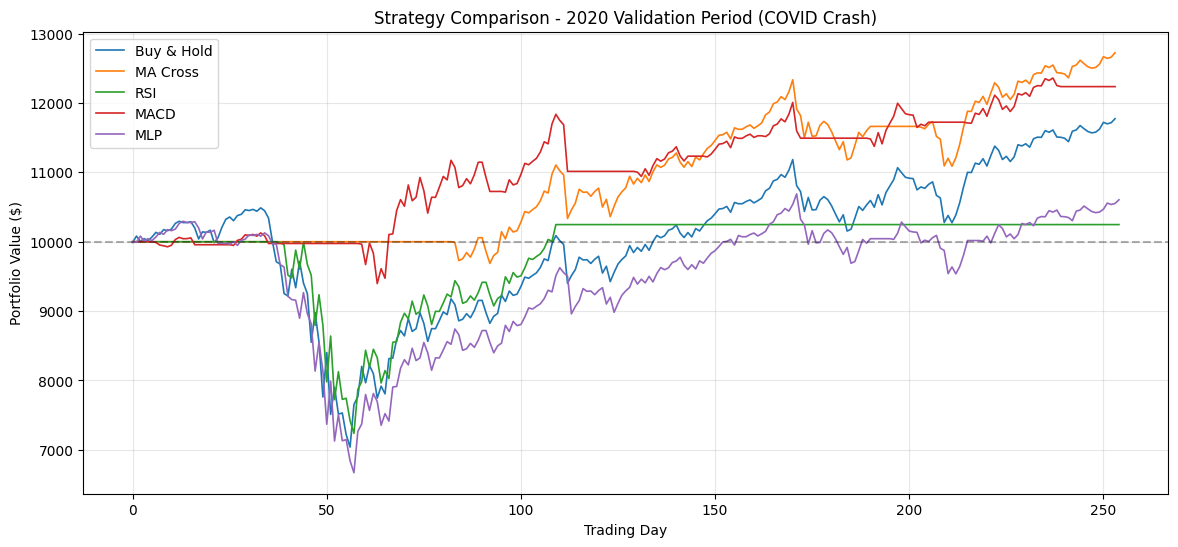

In [14]:
# Portfolio curves comparison - Validation period (most interesting due to COVID)
plt.figure(figsize=(14, 6))
for name, curves in [('Buy & Hold', bnh_curves), ('MA Cross', ma_curves), 
                      ('RSI', rsi_curves), ('MACD', mom_curves), ('MLP', sup_curves)]:
    plt.plot(curves['val'], label=name, linewidth=1.2)

plt.axhline(10000, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Trading Day')
plt.ylabel('Portfolio Value ($)')
plt.title('Strategy Comparison - 2020 Validation Period (COVID Crash)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Validation Period Graph Analysis:**

The 2020 COVID crash (around day 40-60) reveals each strategy's character:

1. **B&H (blue)** plunges deepest (-33%) then fully recovers - highest volatility
2. **MA Cross (orange)** exits before the worst of the crash, re-enters on recovery - smoothest ride
3. **MACD (green)** also exits early but re-enters faster due to shorter signal lag
4. **RSI (red)** stays flat during crash (wasn't invested) then buys near the bottom
5. **MLP (purple)** follows B&H closely since it can't predict the crash

**Key insight:** Trend-following (MA, MACD) provides crash protection that supervised learning cannot. This is the core value proposition for RL - learning risk management behaviors that aren't captured by prediction accuracy alone.

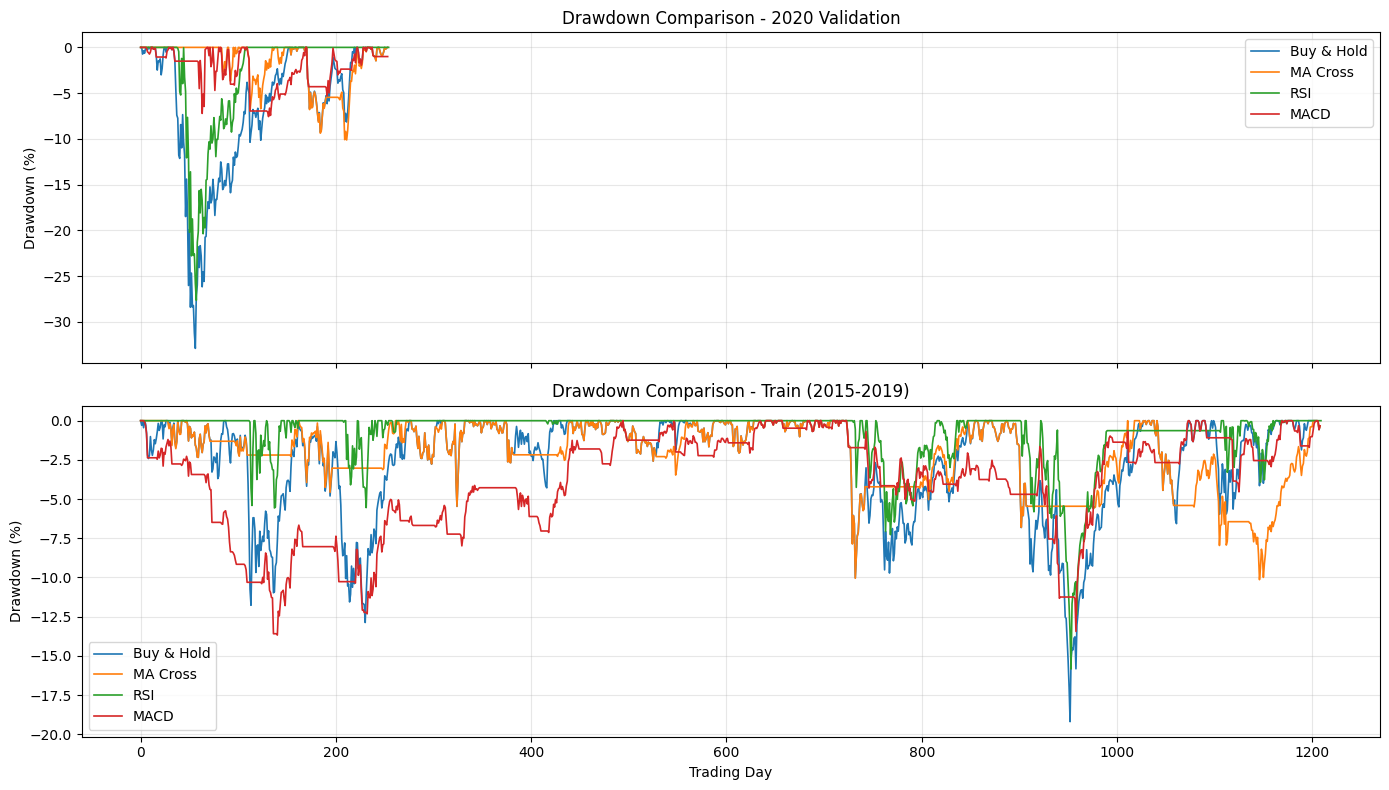

In [15]:
# Drawdown comparison - Validation
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for name, curves in [('Buy & Hold', bnh_curves), ('MA Cross', ma_curves), 
                      ('RSI', rsi_curves), ('MACD', mom_curves)]:
    vals = np.array(curves['val'])
    peak = np.maximum.accumulate(vals)
    dd = (vals - peak) / peak * 100
    axes[0].plot(dd, label=name, linewidth=1.2)

axes[0].set_ylabel('Drawdown (%)')
axes[0].set_title('Drawdown Comparison - 2020 Validation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Train period
for name, curves in [('Buy & Hold', bnh_curves), ('MA Cross', ma_curves), 
                      ('RSI', rsi_curves), ('MACD', mom_curves)]:
    vals = np.array(curves['train'])
    peak = np.maximum.accumulate(vals)
    dd = (vals - peak) / peak * 100
    axes[1].plot(dd, label=name, linewidth=1.2)

axes[1].set_ylabel('Drawdown (%)')
axes[1].set_xlabel('Trading Day')
axes[1].set_title('Drawdown Comparison - Train (2015-2019)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Drawdown Analysis:**

The drawdown charts make the risk differences even clearer:
- B&H has the deepest drawdowns in both periods
- MA Crossover and MACD limit drawdowns significantly - they spend less time underwater
- This is the fundamental trade-off: give up some upside for much better downside protection

For an RL agent, the ideal behavior would be:
1. Hold during strong uptrends (like B&H)
2. Exit when trend breaks (like MA Crossover)
3. Re-enter quickly when momentum resumes (like MACD)

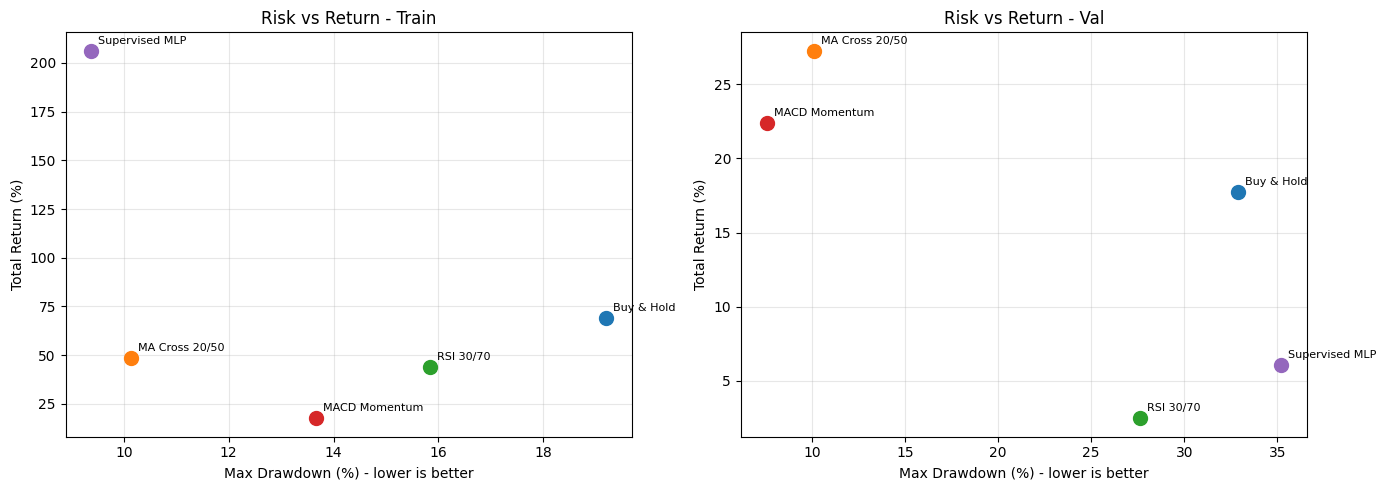

In [16]:
# Risk-return scatter
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for split_idx, split in enumerate(['train', 'val']):
    ax = axes[split_idx]
    for name, metrics in strategies.items():
        m = metrics[split]
        ax.scatter(-m['max_drawdown'], m['total_return'], s=100, zorder=5)
        ax.annotate(name, (-m['max_drawdown'], m['total_return']), 
                    textcoords='offset points', xytext=(5, 5), fontsize=8)
    
    ax.set_xlabel('Max Drawdown (%) - lower is better')
    ax.set_ylabel('Total Return (%)')
    ax.set_title(f'Risk vs Return - {split.title()}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Risk-Return Scatter Analysis:**

The ideal position is upper-left (high return, low drawdown). On the validation chart:
- **MA Cross and MACD** sit in the upper-left quadrant: best risk-adjusted performance
- **B&H** has decent return but worst risk
- **Supervised MLP** offers no advantage over B&H

The RL agent target zone is above and to the left of B&H on both charts.

In [ ]:
baseline_config = {}
for strat_name, splits in strategies.items():
    baseline_config[strat_name] = splits

baseline_config['rl_targets'] = {
    'min_val_return': 0.0,
    'target_val_sharpe': max(m['sharpe'] for m in [bnh_metrics['val'], ma_metrics['val']]),
    'target_val_max_dd': max(m['max_drawdown'] for m in [ma_metrics['val'], mom_metrics['val']]),
    'description': 'RL must beat random, should match B&H returns with MA-level drawdowns'
}

with open('models/baseline_config.json', 'w') as f:
    json.dump(baseline_config, f, indent=2, default=float)

print("Saved models/baseline_config.json")

Saved models/baseline_config.json
